# Fine-tune wav2vec2-xls-r on labeled speech data from one language 

The code to fine-tune wav2vec2-xls-r was adapted from the tutorial by  [Von Platen (2021)](https://huggingface.co/blog/fine-tune-xlsr-wav2vec2)

From the speech signal to the output text the pipeline is illustrated in the figure below. 

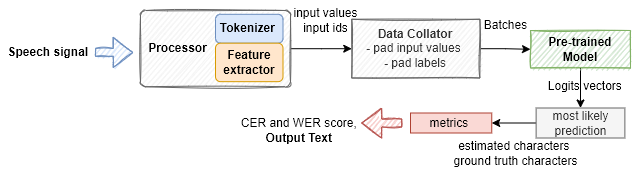 






First we need to install and import HuggingFace datasets, transformers, libraries, and packages (the versions may change)

In [ ]:
%%capture 
!pip install datasets==2.1.0
!pip install transformers==4.18 
!pip install huggingface_hub==0.5.1 
!pip install torchaudio==0.11  
!pip install librosa 
!pip install jiwer   
!git config --global credential.helper store 
!apt install git-lfs

In [ ]:
%%capture 
import pandas as pd
import re
import torch
import json
import os
import numpy as np
from typing import Any, Dict, List, Optional, Union
from IPython.display import display, HTML
from transformers import Wav2Vec2ForCTC, Wav2Vec2CTCTokenizer, AutoModelForCTC, Wav2Vec2Processor
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union
from datasets.utils.version import Version
from datasets import load_dataset, load_metric, Audio
from torch import Tensor
#import sys
#import argparse

## **Load the dataset**

We are going to retrieve the speech data from the [Mozilla Common Voice](https://commonvoice.mozilla.org/en/datasets) dataset [(Ardila et al., 2020)](https://github.com/common-voice/cv-dataset). 

check thelanguage code and the number of the corpus you want to load

In [ ]:
lang = "it"            # language code 
train_pct = 10         # the percentange that you want to use to train the model 
corpus = 6.1           # the number of the corpus of the language

In [ ]:
"""load dataset"""

if corpus == 6.1 : 
    common_voice_train = load_dataset("common_voice", lang , split=f"train[:{train_pct}%]")
    common_voice_train = common_voice_train.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "segment", "up_votes"])
    common_voice_test = load_dataset("common_voice", lang, split="test[:10%]")
    common_voice_test = common_voice_test.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "segment", "up_votes"])
    common_voice_validation = load_dataset("common_voice", lang, split="validation[:10%]")
    common_voice_validation = common_voice_validation.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "segment", "up_votes"])
else: 
    common_voice_train = load_dataset(f"mozilla-foundation/common_voice_{corpus}_0/", lang, use_auth_token=True)
    ommon_voice_train = common_voice_train.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "segment", "up_votes"])
    common_voice_test = load_dataset(f"mozilla-foundation/common_voice_{corpus}_0/", lang  , split="test[:10%]", use_auth_token=True)    
    common_voice_test = common_voice_test.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "segment", "up_votes"])
    common_voice_validation = load_dataset(f"mozilla-foundation/common_voice_{corpus}_0/", lang , split="validation[:10%]", use_auth_token=True)
    common_voice_validation = common_voice_validation.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "segment", "up_votes"])


Look how many files are in each set 

In [ ]:
len_train = len(common_voice_train)
len_test = len(common_voice_test)
len_validation=len(common_voice_validation)

print(f"Number of Audio files per each set:\n train: {len_train},\n test: {len_test},\n validation: {len_validation}")


Number of Audio files per each set:
 train: 5802,
 test: 1293,
 validation: 1293


## **Pre-process the data**
remove the punctuation and lowercase the transcribed sentences



In [ ]:
"""Preprocessing Dataset"""

print("preprocess data")
import re
if lang == "ar":
    chars_to_remove_regex = '[\—\,\?\.\!\-\;\:\"\“\%\�\°\(\)\–\…\¿\¡\,\""\‘\”\჻\~\՞\؟\،\,\॥\«\»\„\,\“\”\「\」\‘\’\《\》\[\]\{\}\=\`\_\+\<\>\‹\›\©\®\→\。\、\﹂\﹁\～\﹏\，\【\】\‥\〽\『\』\〝\⟨\⟩\〜\♪\؛\/\\\−\^\'\ʻ\ˆ\´\ʾ\‧\〟\'ً \'ٌ\'ُ\'ِ\'ّ\'ْ]'
else:
    chars_to_remove_regex = '[\,\?\.\!\-\;\:\"\“\%\‘\”\�\°\(\)\–\…\\\[\]\«\»\\\/\^\<\>\~\_\-\¿\¡\—]'

def remove_special_characters(batch):
    batch["sentence"] = re.sub(chars_to_remove_regex, '', batch["sentence"]).lower()
    return batch

common_voice_train = common_voice_train.map(remove_special_characters)
common_voice_test = common_voice_test.map(remove_special_characters)
common_voice_validation = common_voice_validation.map(remove_special_characters)


preprocess data


  0%|          | 0/5802 [00:00<?, ?ex/s]

  0%|          | 0/1293 [00:00<?, ?ex/s]

  0%|          | 0/1293 [00:00<?, ?ex/s]

Use this function to substitute characters in the transcriptions

In [ ]:
def replace_characters(batch):
    batch["sentence"] = re.sub('[’]', "'", batch["sentence"])
    return batch
common_voice_train = common_voice_train.map(replace_characters)
common_voice_test = common_voice_test.map(replace_characters)
common_voice_validation = common_voice_validation.map(replace_characters)

  0%|          | 0/5802 [00:00<?, ?ex/s]

  0%|          | 0/1293 [00:00<?, ?ex/s]

  0%|          | 0/1293 [00:00<?, ?ex/s]

## Create or Import the **tokenizer**

### **Create** the vocabulary of the language from from the characters in the transcription
- extract the characters from the sentences 





In [ ]:
def extract_all_chars(batch):
  all_text = " ".join(batch["sentence"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

vocab_train = common_voice_train.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_train.column_names)
vocab_test = common_voice_test.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_test.column_names)
vocab_validation = common_voice_validation.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_test.column_names)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

- create a list of characters of the language 

!! The transcriptions can contain foreign characters, check the dictionary.
Alternatively create your own vocab_list


In [ ]:
vocab_list = list(set(vocab_train["vocab"][0]) | set(vocab_test["vocab"][0]))
# """uncomment and create your own vocab_list"""
#vocab_list = ["'", " ", "a", "b","c","d","e","f","g","h","i","j","k","l","m","n","o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]

vocab_dict = {v: k for k, v in enumerate(sorted(vocab_list))}
print(vocab_dict) 

{' ': 0, "'": 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27}


- add CTC tokens: 
  - PAD token is used to differentiate between alignments
  - UNK for unknown characters (not encountered in the training set)
  - "|" signalizes a word boundary 

In [ ]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

30

- write the dictionary in a json file  
- save the tokenizer in a local directory 

In [ ]:
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("./", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

print("saving tokenizer")
tokenizer.save_pretrained(f"./wav2vec2-large-xls-r-300m-{lang}")  

saving tokenizer


('./wav2vec2-large-xls-r-300m-it/tokenizer_config.json',
 './wav2vec2-large-xls-r-300m-it/special_tokens_map.json',
 './wav2vec2-large-xls-r-300m-it/vocab.json',
 './wav2vec2-large-xls-r-300m-it/added_tokens.json')

### **Import** the tokenizer from a local folder

In [ ]:
print("load tokenizer form local folder")
tokenizer= Wav2Vec2CTCTokenizer.from_pretrained(f"/content/drive/MyDrive/tokenizer_{lang}/", local_files_only=True)

load tokenizer form local folder


## Define the **feature extractor** pipeline

The data are passed to the processor, an object that contains the tokenizer and the feature extractor. Here, the feature extractor transforms the audio signal into feature vectors that will be passed to the model as input. The data are normalized and the transcriptions were encoded as labels.

In [ ]:
"""Feature Extractor"""
from transformers import Wav2Vec2FeatureExtractor
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)
"""Processor"""
from transformers import Wav2Vec2Processor
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)


## Downsampling
The discretized speech signals were down-sampled to 16000 Hz 

In [ ]:
print("downsampling from 48000 to 16000")
common_voice_train = common_voice_train.cast_column("audio", Audio(sampling_rate=16_000))
common_voice_test = common_voice_test.cast_column("audio", Audio(sampling_rate=16_000))
common_voice_validation = common_voice_validation.cast_column("audio", Audio(sampling_rate=16_000))


downsampling from 48000 to 16000


## Prepare data for the model 

In [ ]:
print("prepare dataset")
def prepare_dataset(batch):
    audio = batch["audio"]
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])
    with processor.as_target_processor():
        batch["labels"] = processor(batch["sentence"]).input_ids
    return batch

common_voice_train = common_voice_train.map(prepare_dataset, remove_columns=common_voice_train.column_names)
common_voice_test = common_voice_test.map(prepare_dataset, remove_columns=common_voice_test.column_names)
common_voice_validation = common_voice_validation.map(prepare_dataset, remove_columns=common_voice_validation.column_names)


prepare dataset


  0%|          | 0/5802 [00:00<?, ?ex/s]

  0%|          | 0/1293 [00:00<?, ?ex/s]

  0%|          | 0/1293 [00:00<?, ?ex/s]

## (Optional) filter the audio file setting a threashold 
The audio files have been filtered by length considering only those with a duration below the threshold of 5 seconds.
This can help with memory problems and to get a better sampling in some cases.  

In [ ]:
print("keep only audios < 5 seconds length")
max_input_length_in_sec = 5.0
common_voice_train = common_voice_train.filter(lambda x: x < max_input_length_in_sec*processor.feature_extractor.sampling_rate, input_columns=["input_length"])
common_voice_test = common_voice_test.filter(lambda x: x < max_input_length_in_sec*processor.feature_extractor.sampling_rate, input_columns=["input_length"])
common_voice_validation = common_voice_validation.filter(lambda x: x < max_input_length_in_sec*processor.feature_extractor.sampling_rate, input_columns=["input_length"])

"""see the length filtered"""
def Audio_len_filter(common_voice_set):
    len_t =0
    for el in common_voice_set:
        T= el["input_length"]/16000
        len_t= len_t+T

    return len_t

len_tr_filter = Audio_len_filter(common_voice_train)
len_ts_filter = Audio_len_filter(common_voice_test)
len_val_filter=Audio_len_filter(common_voice_validation)
print("Filtered duration in seconds: \nTrain Set:", len_tr_filter, "\nTest Set:", len_ts_filter , "\nValidation Set:", len_val_filter)

keep only audios < 5 seconds length


  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Filtered duration in seconds: 
Train Set: 11813.591999999999 
Test Set: 1965.5039999999976 
Validation Set: 2281.392


## Data Collator 
The “data collator” object pads differently the labels and input values and batches the samples.

In [ ]:
"""Data Collator"""
@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels
        return batch

data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)


## Load the Metrics 

The function to compute the metrics takes as input the output predictions of the model and the transcriptions to calculate the error rate. 
We measure Character and Word Error Rate (CER, WER). 

In [ ]:
"""Metrics CER WER"""
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)
    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id
    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    print("wer:", wer )
    print("cer:", cer)

    return {"wer": wer, 
            "cer": cer,}


## Load the pre-trained model

adapt hyper-parameters on your case 

In [ ]:
from transformers import Wav2Vec2ForCTC
print('loading pretrained model')

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-xls-r-300m", 
    attention_dropout=0.0,
    hidden_dropout=0.0,
    feat_proj_dropout=0.0,
    mask_time_prob=0.05,
    layerdrop=0.0,
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer),
) 

We train only the decoder, so the feature extarctor (where the acoustic features are extracted) is “frozen”. It was sufficiently trained in pre-training. 

In [ ]:
model.freeze_feature_extractor()

## Training Parameters 
Set the hyperparameters:
- batch size was set to 4
- learning rate was 3*10-4
- gradient accumulation was 2 
- warmup steps equal 500

Here the directory where the fine-tuned model will be saved is given. 

In [ ]:
"""Training Parameters"""
from transformers import TrainingArguments
training_args = TrainingArguments(
  output_dir= f"wav2vec2-large-xls-r-300m-{lang}-{train_pct}",
  group_by_length=True,
  per_device_train_batch_size=4,  ## change from 16 to 4
  per_device_eval_batch_size=4,  
  gradient_accumulation_steps=2,
  evaluation_strategy="epoch",    ## changed from steps to epoch
  num_train_epochs=30,
  gradient_checkpointing=True,
  fp16=True,
  #save_steps=400,
  #eval_steps=400,
  #logging_steps=400,
  learning_rate=3e-4,
  warmup_steps=500,
  save_total_limit=2,
  save_strategy= "epoch",            
  metric_for_best_model="eval_loss", 
  load_best_model_at_end = True,  
  )

## Define the Trainer

we train the model on the train set and evaluate on the validation set 

To reduce the risk of overfitting the model, the callback “early stoppings” was added to stop the training if the metrics worsen after 3 evaluation calls. Finally, the sample batches were fed to the pre-trained model and the training started.


In [ ]:
"""Trainer"""
from transformers import Trainer, EarlyStoppingCallback 

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=common_voice_train,
    eval_dataset=common_voice_validation,
    tokenizer=processor.feature_extractor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

## **Train** the model 

to restart the training un comment the line and it will restart training from the last checkpoint saved

In [ ]:
print("TRAINING")
trainer.train()
#trainer.train(resume_from_checkpoint = True)   # uncomment to restart the traing from last checkpoint
print("ENDED TRAINING")


# Done! 
The last checkpoint has been saved in the directory you specified previously.

